# Домашнее задание № 10

# Поиск выбросов и генерация новых признаков

In [68]:
# загрузим базовые библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

1. Получение данных

In [69]:
# подключаемся к Glass Classification
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/glass")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/glass/versions/1


In [70]:
# считываем данные
path = '/root/.cache/kagglehub/datasets/uciml/glass/versions/1/glass.csv'
df = pd.read_csv(path)
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Целевая переменная – тип стекла 'Type'. Остальные признаки описывают химические элементы в составе материала.

In [71]:
target = 'Type'

2. Первичный анализ

In [73]:
# посмотрим размер
df.shape

(214, 10)

In [74]:
# количество уникальных значений
df.nunique()

,0
RI,178
Na,142
Mg,94
Al,118
Si,133
K,65
Ca,143
Ba,34
Fe,32
Type,6


In [109]:
# посмотрим сколько у нас классов
df[target].unique()

array([1, 2, 3, 5, 6, 7])

In [75]:
# проверим на пропуски
df[df.isna().any(axis=1)]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type


3. Разделим выборку на обучающую и тестовую

In [76]:
# разобъем датасет на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target),
                                                    df[target],
                                                    test_size=0.2, random_state=42
                                                    )

Обучим модель на RandomForestClassifier() на не обработанных данных

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

подберем лучшие параметры

In [78]:
n_samples = df.shape[0]
n_features = df.shape[1]

RFC_param_grid = {'n_estimators': [20,50,100],
                  'max_depth': [None, 2, 5,],
                  'min_samples_split': [2, 0.5, n_samples//2,],
                  'min_samples_leaf': [1, 0.5, n_samples//2,],
                  'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,0.5, n_features//2],
                  'bootstrap':[True, False],
                 }

In [79]:
rf_classifier_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                                  param_grid=RFC_param_grid,
                                  n_jobs=-1,
                                  cv=3,
                                  verbose=1,
                                  refit=True    # для получения лучшей функции
                                 )
rf_classifier_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1134 candidates, totalling 3402 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
486 fits failed out of a total of 3402.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
252 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 2, 5],
                         'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,
                                          0.5, 5],
                         'min_samples_leaf': [1, 0.5, 107],
                         'min_samples_split': [2, 0.5, 107],
                         'n_estimators': [20, 50, 100]},
             verbose=1)

In [80]:
# посмотрим на оптимальные параметры
rf_classifier_grid.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [81]:
# Получим нашу лучшую модель
model_best_RFC = rf_classifier_grid.best_estimator_
model_best_RFC

RandomForestClassifier(max_features=0.3, n_estimators=50, random_state=42)

5. Получим предсказания и отчет о классификации

In [82]:
# получим предсказания
y_pred = model_best_RFC.predict(X_test)

In [83]:
# вычислим точность модели
model_best_RFC.score(X_test, y_test)

0.8372093023255814

In [84]:
# получим отчет о классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      1.00      0.85        11
           2       0.83      0.71      0.77        14
           3       1.00      0.67      0.80         3
           5       1.00      0.50      0.67         4
           6       1.00      1.00      1.00         3
           7       0.89      1.00      0.94         8

    accuracy                           0.84        43
   macro avg       0.91      0.81      0.84        43
weighted avg       0.86      0.84      0.83        43



Ради интереса посмотрим, что нам добавит BaggingClassifier() на не обработанной выборке

In [85]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [95]:
n_samples = df.shape[0]
n_features = df.shape[1]

BC_param_grid = {
                 'bootstrap': [True, False],
                 'bootstrap_features': [True, False],
                 'n_estimators': [5, 10, 15],  # количество деревьев, которые будут использоваться в ансамбле.
                 'max_samples' : [0.6, 0.8, 1.0],
                 'max_features' : [0.6, 0.8, 1.0],
                 'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,0.5, n_features//2]
                }

In [97]:
bc_classifier_grid = GridSearchCV(BaggingClassifier(estimator=RandomForestClassifier(random_state=42)),
                                  param_grid=BC_param_grid,
                                  n_jobs=-1,  # используем все доступные процессоры
                                              # по умолчанию None (1 задание)
                                  cv=5,       # количество разрезов кросс-валидации
                                              # по умолчанию cv=5
                                  refit=True  # для получения лучшей функции
                                 )
bc_classifier_grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 1260.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/va

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=RandomForestClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,
                                          0.5, 5],
                         'max_samples': [0.6, 0.8, 1.0],
                         'n_estimators': [5, 10, 15]})

Даже для такого маленького датасета считаем ну очень долго

In [99]:
# посмотрим на оптимальные параметры
bc_classifier_grid.best_params_

{'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 5,
 'max_samples': 1.0,
 'n_estimators': 10}

In [100]:
# Сохраним нашу лучшую модель
model_best_BC = bc_classifier_grid.best_estimator_
model_best_BC

BaggingClassifier(bootstrap=False, bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42),
                  max_features=5)

In [101]:
# получаем предсказания
y_pred = model_best_BC.predict(X_test)

In [102]:
# вычислим точность модели
model_best_BC.score(X_test, y_test)

0.813953488372093

In [103]:
# получим отчет о классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.69      1.00      0.81        11
           2       0.91      0.71      0.80        14
           3       1.00      0.33      0.50         3
           5       1.00      0.75      0.86         4
           6       1.00      0.67      0.80         3
           7       0.80      1.00      0.89         8

    accuracy                           0.81        43
   macro avg       0.90      0.74      0.78        43
weighted avg       0.85      0.81      0.80        43



Точность намного хуже. Думаю это объясняется малым количеством исходных данных

6. Обработка выбросов

а) визуализация

In [138]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

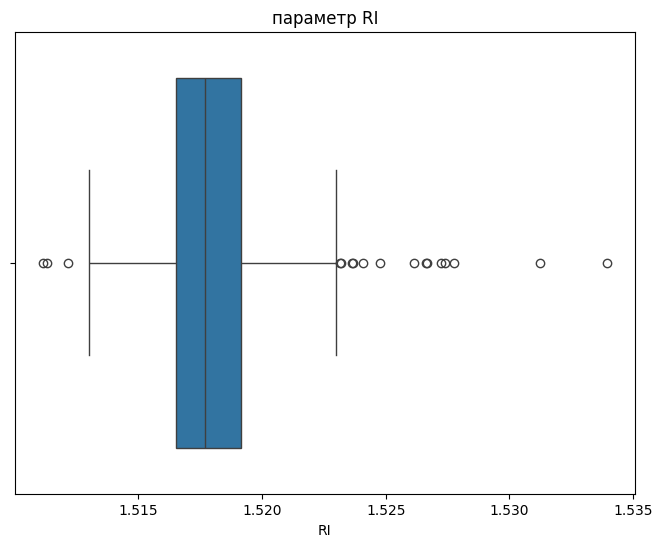

In [142]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['RI'])
plt.title('параметр RI')
plt.show()

б) исследование признаков на выбросы

 Обнаружение неконтролируемых выбросов с использованием локального коэффициента выбросов (LOF)

In [135]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=6)

clf.fit_predict(X_test)

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1, -1,  1,  1,  1])

In [136]:
clf.negative_outlier_factor_

array([-1.0148831 , -1.0327388 , -1.20134132, -1.0396365 , -1.52681123,
       -1.99992944, -0.97190446, -1.02010398, -1.00502248, -1.06285089,
       -1.33217071, -1.5072029 , -0.95542527, -1.03216673, -1.56920717,
       -1.54046386, -2.02927639, -1.30614094, -1.2895526 , -2.89555375,
       -1.37693651, -0.97648413, -1.00556   , -0.9863058 , -0.96185917,
       -1.58057868, -0.97248194, -1.0539376 , -1.48194557, -0.98486951,
       -1.43863262, -1.04559839, -1.24956445, -0.97700435, -1.33932259,
       -0.9863058 , -5.69332666, -1.50502287, -1.35056902, -2.61547153,
       -1.44579097, -0.97648413, -1.17664329])

In [137]:
outliers = df[lof.negative_outlier_factor_ < lof.offset_]
valid_samples = df[lof.negative_outlier_factor_ >= lof.offset_]


NameError: name 'lof' is not defined